## The Goal: read in data from previous simulations with CLUBB output (monthly) detailing wind variance and skewness. Save a few time averages out as pickle files for easier manipulation. 
Author: Meg D. Fowler <br>
Date: 10 Aug 2020<br><br>

In [1]:
# Load libraries

# Plotting utils 
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import matplotlib.ticker as ticker 
import cartopy
import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy.util

# Analysis
import Ngl
import numpy
import Nio
import os
import numpy as np 
import xarray as xr
from datetime import date, timedelta
import pandas as pd 


## Read in data

In [2]:
# Set up directories 
dataDir    = '/Users/meganfowler/Documents/NCAR/Analysis/CLUBB_initial/data/'
#dataDir   = '/glade/work/mdfowler/data/CLUBB_sim/'   # on Casper/Cheyenne 
nameStart = 'f.e20.FHIST.f09_f09.cesm2_1.001.cam.h0.'
nameEnd   = '_CLUBBwinds.nc'

decadeList = ['1951-59','1960-69', '1970-79','1980-89','1990-99','2000-14']


In [3]:
# Read in example file to get some constant fields
testName = dataDir+nameStart+'1990-01.nc'
testDF   = xr.open_dataset(testName)

# Set lat, lon 
lat = testDF.lat
lon = testDF.lon

# Make land mask
landFrac = np.squeeze(testDF.LANDFRAC.values)
# Define as 'land' gridcell if land fraction > 0.5
landMask = np.zeros([len(lat),len(lon)])
landMask[landFrac > 0.5] = 1


**Plot land mask to make sure this <i>is</i> what I wanted**

Text(0.5, 1.0, 'Land Mask (Sanity Check)')

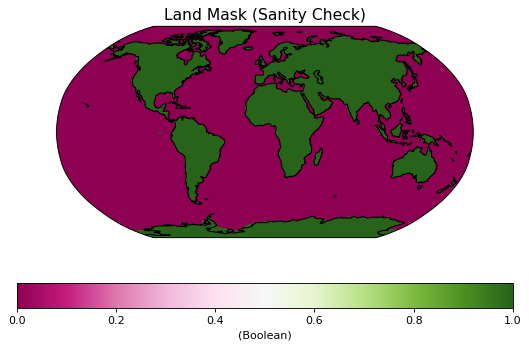

In [99]:
# Plot land mask
fig=plt.figure(figsize=(8, 5), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
landMask_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(landMask, lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,lat,landMask_cyclic,cmap='PiYG',transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='(Boolean)',orientation='horizontal')
ax.set_title('Land Mask (Sanity Check)', fontsize=14)


**Now start <i>actually</i> reading in data**

In [4]:
# Read in data by decade 
for iDec in range(len(decadeList)): 
    
    # Open datasets for each decade 
    fileName = dataDir+nameStart+decadeList[iDec]+nameEnd
    dataDF   = xr.open_dataset(fileName, decode_times=True)
    dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


    PSfile = dataDir+nameStart+decadeList[iDec]+'_PS.nc'
    presDF = xr.open_dataset(PSfile, decode_times=True)
    presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime

    # Create *giant* datasets that span the full period of the simulations
    if iDec==0:
        fullDF = dataDF
        fullPS = presDF
    else:
        fullDF = xr.concat([fullDF, dataDF], dim="time")
        fullPS = xr.concat([fullPS, presDF], dim="time")
        
    print('Done with decade ', decadeList[iDec], ' ... ')
    print('    Number of times saved: ', len(fullDF['time']))
    

<ipython-input-4-319b86f5c9c1>:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  dataDF['time'] = dataDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime
<ipython-input-4-319b86f5c9c1>:12: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'noleap', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  presDF['time'] = presDF.indexes['time'].to_datetimeindex() # Convert from cf time (non-standard calendar) to datetime


Done with decade  1951-59  ... 
    Number of times saved:  108
Done with decade  1960-69  ... 
    Number of times saved:  228
Done with decade  1970-79  ... 
    Number of times saved:  348
Done with decade  1980-89  ... 
    Number of times saved:  468
Done with decade  1990-99  ... 
    Number of times saved:  588
Done with decade  2000-14  ... 
    Number of times saved:  768


Since ideally, I'd like to be able to access the time attributes fairly easily, I'm going to put those into a separate pandas array.<br> That way they can be indexed via dates.year, dates.month, etc. <br> 
    
Note: monthly averages are saved at the first time step of the <i>next</i> month. So to get January averages for example, you'd want dates.month==2. <br>

In [5]:
# To be able to easily access years, months, days - use Pandas 
dates = pd.DatetimeIndex(fullDF['time'].values) 


## Look at some statistics 

In [6]:
# Read into individual arrays for easy access

UP2 = fullDF.UP2_CLUBB      # Zonal velocity variance (m2/s2)
VP2 = fullDF.VP2_CLUBB      # Meridional velocity variance (m2/s2)
WP2 = fullDF.WP2_CLUBB      # Vertical velocity variance (m2/s2)
WP3 = fullDF.WP3_CLUBB      # Third moment vertical velocity (m3/s3)
PS  = fullPS.PS             # Surface pressure (Pa)

np.shape(WP3)

(768, 33, 192, 288)

In [51]:
# Flip along vertical (level) axis, so that index 0 is surface 
UP2 = np.flip(UP2, axis=1)
VP2 = np.flip(VP2, axis=1)
WP2 = np.flip(WP2, axis=1)
WP3 = np.flip(WP3, axis=1)


In [60]:
# Save hybrid sigma levels into array 
levs = np.flip(fullDF.ilev.values)


In [52]:
# Take (annual) time means to look at a few PDFs 
UP2_timeMean = np.squeeze(np.nanmean(UP2, 0))
VP2_timeMean = np.squeeze(np.nanmean(VP2, 0))
WP2_timeMean = np.squeeze(np.nanmean(WP2, 0))
WP3_timeMean = np.squeeze(np.nanmean(WP3, 0))


In [53]:
# --- Compare to seasonal means --- #
iDJF = np.where((dates.month==1) | (dates.month<=3))[0]
iMAM = np.where((dates.month>=4) & (dates.month<=6))[0]
iJJA = np.where((dates.month>=7) & (dates.month<=9))[0]
iSON = np.where((dates.month>=10) & (dates.month<=12))[0]

# DJF 
UP2_DJFmean = np.squeeze(np.nanmean(UP2[iDJF,:,:,:], 0))
VP2_DJFmean = np.squeeze(np.nanmean(VP2[iDJF,:,:,:], 0))
WP2_DJFmean = np.squeeze(np.nanmean(WP2[iDJF,:,:,:], 0))
WP3_DJFmean = np.squeeze(np.nanmean(WP3[iDJF,:,:,:], 0))
print('Done with DJF means')

# MAM 
UP2_MAMmean = np.squeeze(np.nanmean(UP2[iMAM,:,:,:], 0))
VP2_MAMmean = np.squeeze(np.nanmean(VP2[iMAM,:,:,:], 0))
WP2_MAMmean = np.squeeze(np.nanmean(WP2[iMAM,:,:,:], 0))
WP3_MAMmean = np.squeeze(np.nanmean(WP3[iMAM,:,:,:], 0))
print('Done with MAM means')

# JJA
UP2_JJAmean = np.squeeze(np.nanmean(UP2[iJJA,:,:,:], 0))
VP2_JJAmean = np.squeeze(np.nanmean(VP2[iJJA,:,:,:], 0))
WP2_JJAmean = np.squeeze(np.nanmean(WP2[iJJA,:,:,:], 0))
WP3_JJAmean = np.squeeze(np.nanmean(WP3[iJJA,:,:,:], 0))
print('Done with JJA means')

# SON
UP2_SONmean = np.squeeze(np.nanmean(UP2[iSON,:,:,:], 0))
VP2_SONmean = np.squeeze(np.nanmean(VP2[iSON,:,:,:], 0))
WP2_SONmean = np.squeeze(np.nanmean(WP2[iSON,:,:,:], 0))
WP3_SONmean = np.squeeze(np.nanmean(WP3[iSON,:,:,:], 0))
print('Done with SON means')


Done with DJF means
Done with MAM means
Done with JJA means
Done with SON means


### PDFs

**Zonal velocity variance**

In [42]:
# Specify some parameters for histograms 
UP2_bins     = np.linspace(0.003, 1.0, np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
UP2_binCount = np.full([6, len(UP2_bins)-1], np.nan)
UP2_binWidth = (UP2_bins[1]-UP2_bins[0])/2
UP2_binCent  = UP2_bins[1::] - UP2_binWidth


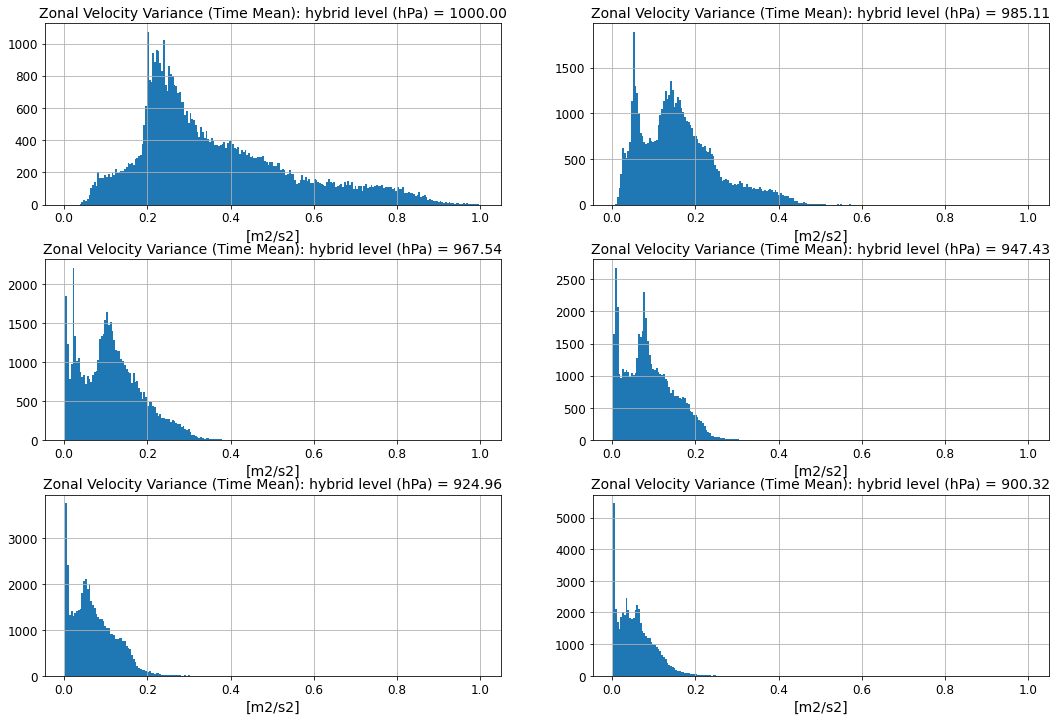

In [63]:
fig, axs = plt.subplots(3,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

for iLev in range(6):
    # Reshape data into 1D array
    UP2_reshape = np.squeeze(UP2_timeMean[iLev,:,:]).reshape((len(lat)*len(lon), 1))
    
    # Plot histogram
    n, bins, patches = axs[iLev].hist(UP2_reshape,bins=UP2_bins)
    axs[iLev].grid()
    #axs[iLev].set_ylim([0,1400])
    axs[iLev].set_title('Zonal Velocity Variance (Time Mean): hybrid level (hPa) = %.2f' % levs[iLev], fontsize=14)
    axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))
    axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
    axs[iLev].tick_params(labelsize=12)

    UP2_binCount[iLev,:] = n 
    

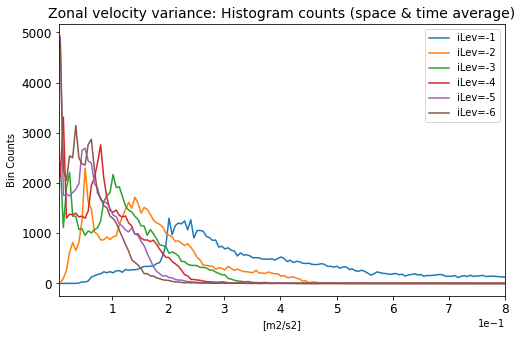

In [38]:
fig, ax1 = plt.subplots(1,1, figsize=(8, 5), facecolor='w', edgecolor='k')

for iLev in range(6):
    ax1.plot(UP2_binCent,UP2_binCount[iLev,:],'-')  # Plot bin counts by level 
    
ax1.legend(['iLev=-1','iLev=-2','iLev=-3','iLev=-4','iLev=-5','iLev=-6'])   # Add legend 
ax1.set_title('Zonal velocity variance: Histogram counts (space & time average)', fontsize=14)
ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0)) # Use scientific notation on x-axis
ax1.set_xlabel('[m2/s2]')        # Add labels to axes 
ax1.set_ylabel('Bin Counts')
ax1.set_xlim([0.005, 0.8])  # Zoom in on the x-axis to more clearly see differences
ax1.tick_params(labelsize=12)    # Set tick font size 



**Meridional Velocity Variance**

In [65]:
# Specify some parameters for histograms 
VP2_bins     = np.linspace(0.003, 1.0, np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
VP2_binCount = np.full([6, len(VP2_bins)-1], np.nan)
VP2_binWidth = (VP2_bins[1]-VP2_bins[0])/2
VP2_binCent  = VP2_bins[1::] - VP2_binWidth


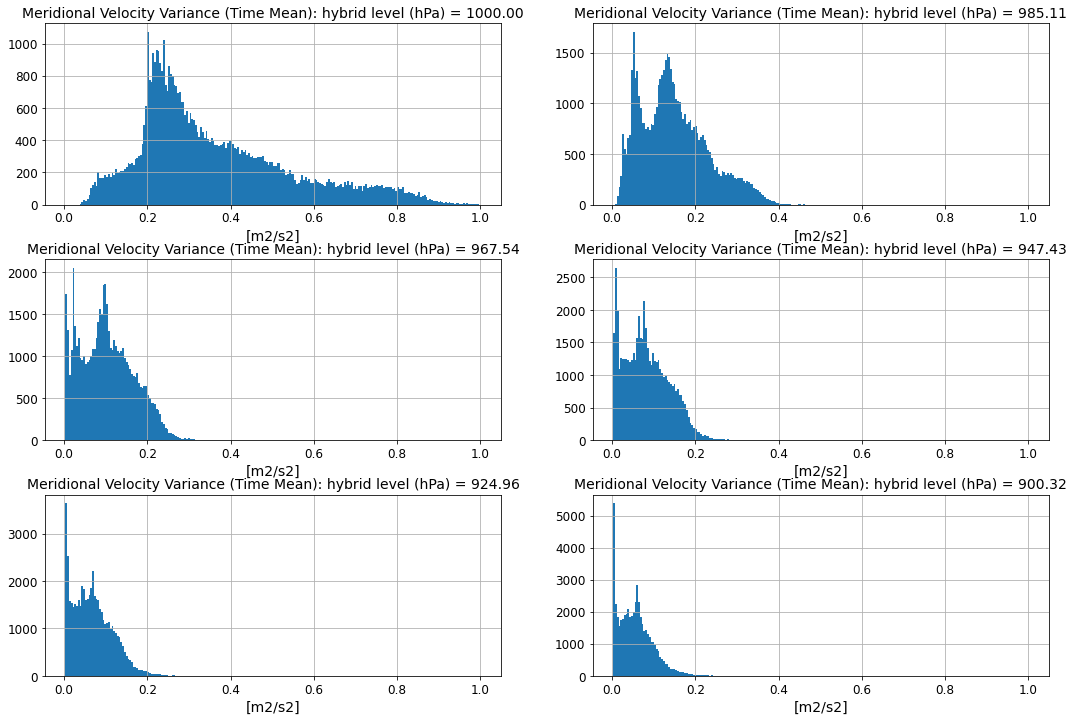

In [69]:
fig, axs = plt.subplots(3,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

for iLev in range(6):
    # Reshape data into 1D array
    VP2_reshape = np.squeeze(VP2_timeMean[iLev,:,:]).reshape((len(lat)*len(lon), 1))
    
    # Plot histogram
    n, bins, patches = axs[iLev].hist(VP2_reshape,bins=VP2_bins)
    axs[iLev].grid()
    #axs[iLev].set_ylim([0,1200])
    axs[iLev].set_title('Meridional Velocity Variance (Time Mean): hybrid level (hPa) = %.2f' % levs[iLev], fontsize=14)
    axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))  #Use scientific notation on x-axis
    axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
    axs[iLev].tick_params(labelsize=12)

    VP2_binCount[iLev,:] = n 


It seems weird to me that at the lowest level, the distribution of VP2_timeMean is exactly the same as UP2_timeMean. Why would vertical and meridional velocity variances be the same at ~surface but get gradually different as you go up in height...? <br>
Just to make sure, let's take a look at the differences between values at a few levels.

In [78]:
print('...Difference between VP2 and UP2 (time means) at various levels...')
print()
for iLev in range(6):
    diffCheck = np.squeeze(VP2_timeMean[iLev,:,:]) - np.squeeze(UP2_timeMean[iLev,:,:])

    print('--Level: %.2f' % (levs[iLev]))
    print('   Avg diff: %.3f' % np.nanmean(diffCheck))
    print('   Max diff: %.3f' % np.nanmax(diffCheck))
    print('   Min diff: %.3f' % np.nanmin(diffCheck))



...Difference between VP2 and UP2 (time means) at various levels...

--Level: 1000.00
   Avg diff: 0.000
   Max diff: 0.000
   Min diff: 0.000
--Level: 985.11
   Avg diff: -0.012
   Max diff: 0.107
   Min diff: -0.184
--Level: 967.54
   Avg diff: -0.011
   Max diff: 0.084
   Min diff: -0.227
--Level: 947.43
   Avg diff: -0.007
   Max diff: 0.064
   Min diff: -0.225
--Level: 924.96
   Avg diff: -0.004
   Max diff: 0.042
   Min diff: -0.197
--Level: 900.32
   Avg diff: -0.001
   Max diff: 0.042
   Min diff: -0.162


**Vertical velocity variance**

In [82]:
# Specify some parameters for histograms 
WP2_bins     = np.linspace(0.003, 0.5, np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
WP2_binCount = np.full([6, len(WP2_bins)-1], np.nan)
WP2_binWidth = (WP2_bins[1]-WP2_bins[0])/2
WP2_binCent  = WP2_bins[1::] - WP2_binWidth


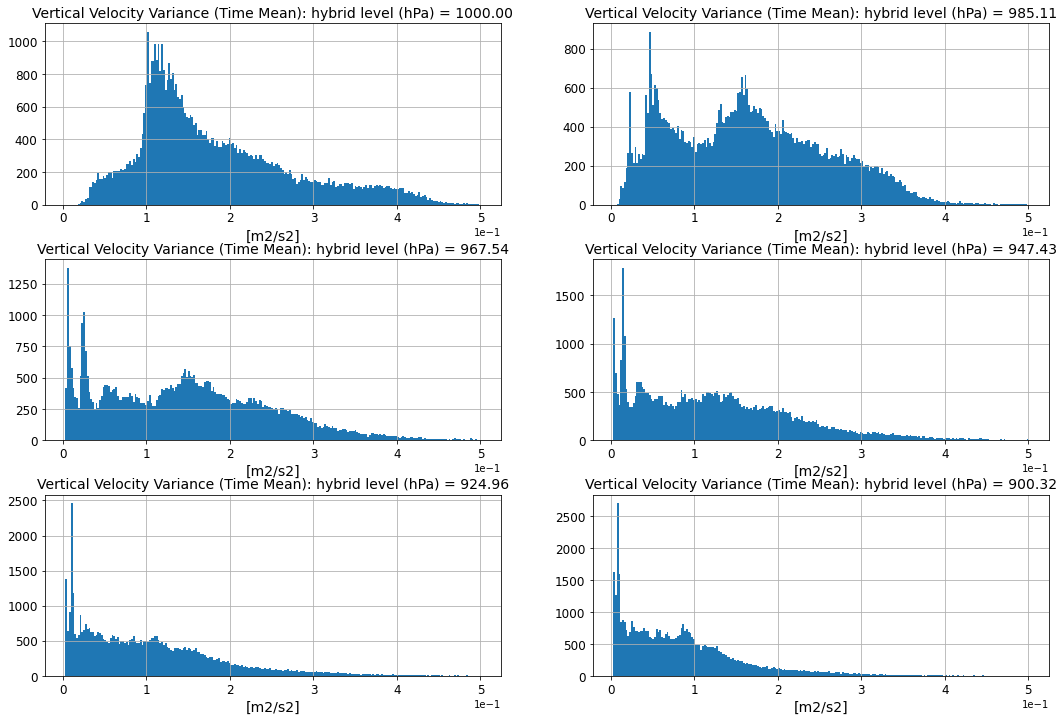

In [83]:
fig, axs = plt.subplots(3,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

for iLev in range(6):
    # Reshape data into 1D array
    WP2_reshape = np.squeeze(WP2_timeMean[iLev,:,:]).reshape((len(lat)*len(lon), 1))
    
    # Plot histogram
    n, bins, patches = axs[iLev].hist(WP2_reshape,bins=WP2_bins)
    axs[iLev].grid()
    #axs[iLev].set_ylim([0,1200])
    axs[iLev].set_title('Vertical Velocity Variance (Time Mean): hybrid level (hPa) = %.2f' % levs[iLev], fontsize=14)
    axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))  #Use scientific notation on x-axis
    axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
    axs[iLev].tick_params(labelsize=12)

    WP2_binCount[iLev,:] = n 



**Vertical velocity skew**

In [88]:
# # Specify some parameters for histograms 
# WP3_bins     = np.linspace(-0.005, 0.05, np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
# WP3_binCount = np.full([6, len(WP3_bins)-1], np.nan)
# WP3_binWidth = (WP3_bins[1]-WP3_bins[0])/2
# WP3_binCent  = WP3_bins[1::] - WP3_binWidth


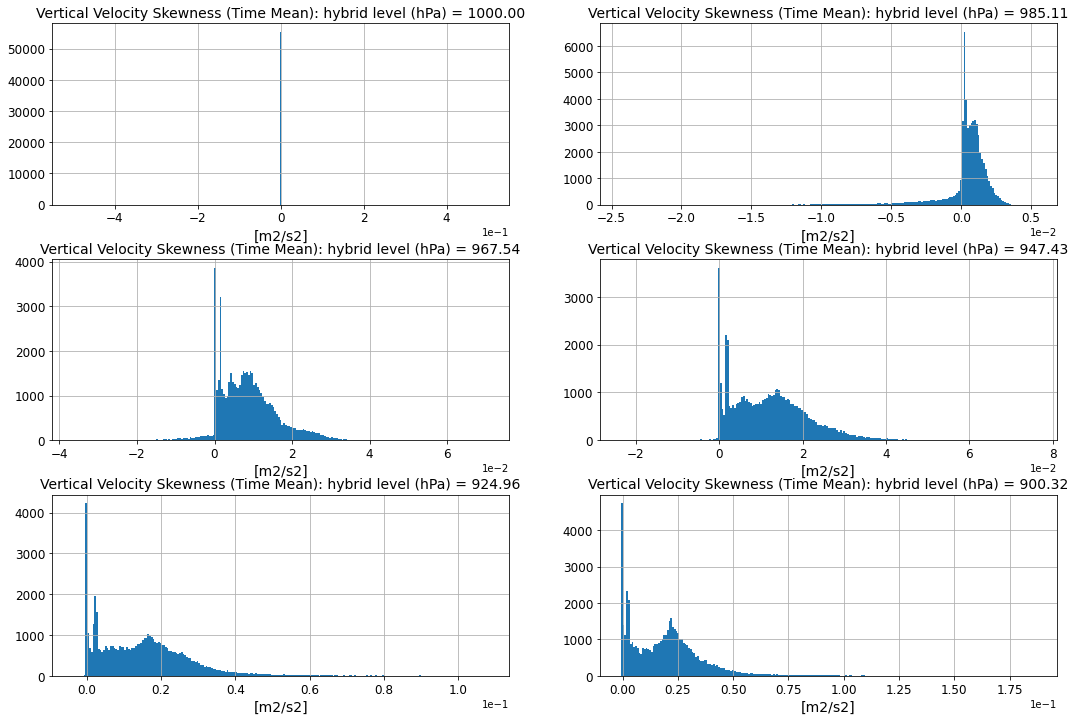

In [105]:
fig, axs = plt.subplots(3,2, figsize=(18, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .3,wspace = 0.2)
axs = axs.ravel()

for iLev in range(6):
    
    # Reshape data into 1D array
    WP3_reshape = np.squeeze(WP3_timeMean[iLev,:,:]).reshape((len(lat)*len(lon), 1))
    
    # Plot histogram
    axs[iLev].hist(WP3_reshape,np.floor(np.sqrt((len(lat)*len(lon)))).astype('int'))
    axs[iLev].grid()
    #axs[iLev].set_ylim([0,1200])
    axs[iLev].set_title('Vertical Velocity Skewness (Time Mean): hybrid level (hPa) = %.2f' % levs[iLev], fontsize=14)
    axs[iLev].ticklabel_format(style='sci',axis='x',scilimits=(0,0))  #Use scientific notation on x-axis
    axs[iLev].set_xlabel('[m2/s2]',fontsize=14)
    axs[iLev].tick_params(labelsize=12)


### Maps

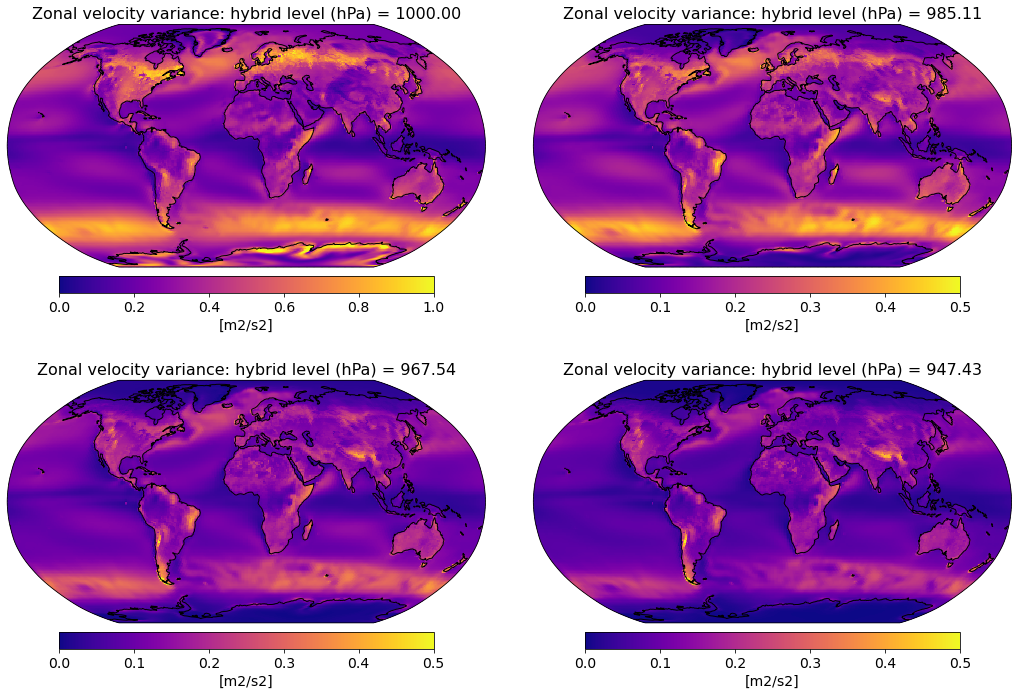

In [100]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    UP2_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_timeMean[iLev,:,:]), dataDF.lon)
    
    if iLev==0:
        cMax = 1
    else: 
        cMax = 0.5
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,UP2_cyclic,
                                        vmin=0,
                                        vmax=cMax,
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Zonal velocity variance: hybrid level (hPa) = %.2f' % levs[iLev], fontsize=16)


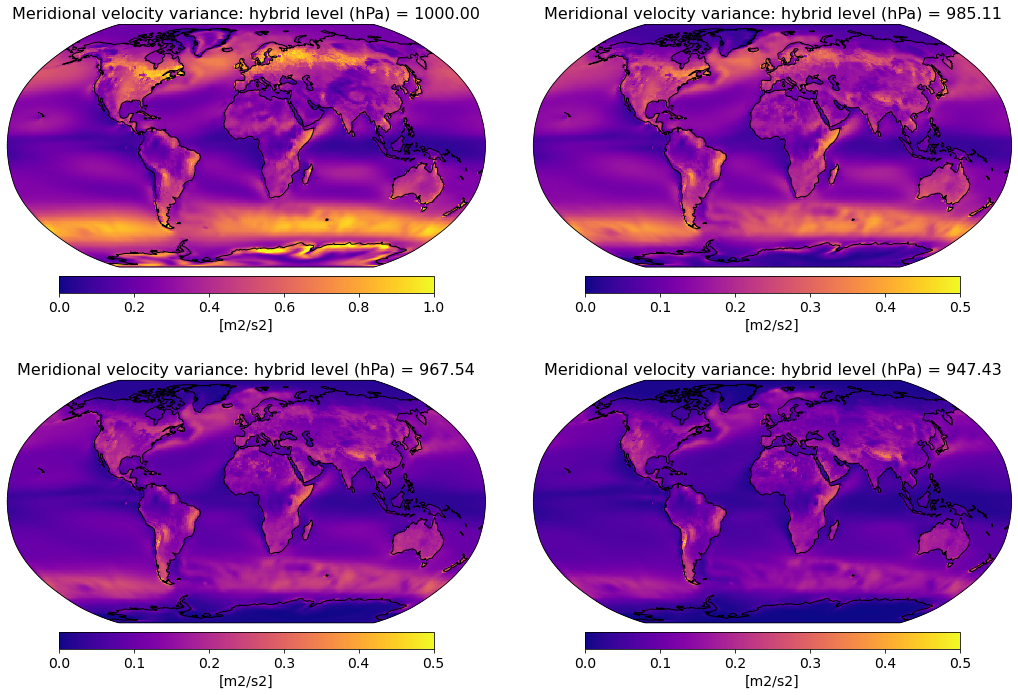

In [110]:
## --- Maps of VP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    VP2_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_timeMean[iLev,:,:]), dataDF.lon)
    
    if iLev==0:
        cMax = 1
    else: 
        cMax = 0.5
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,VP2_cyclic,
                                        vmin=0,
                                        vmax=cMax,
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Meridional velocity variance: hybrid level (hPa) = %.2f' % levs[iLev], fontsize=16)


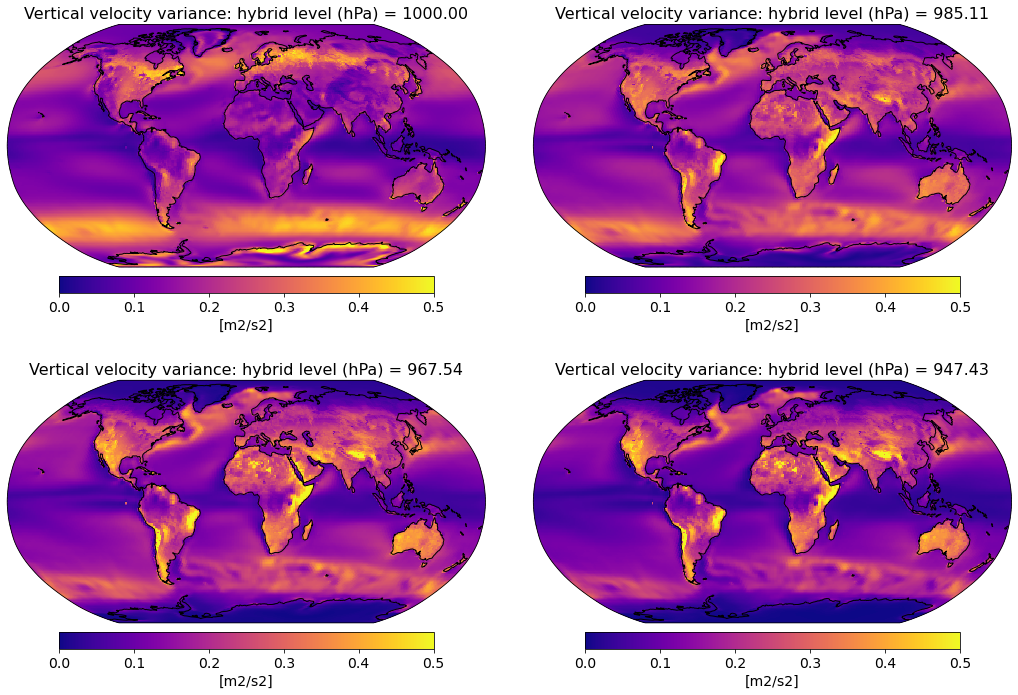

In [117]:
## --- Maps of WP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    WP2_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(WP2_timeMean[iLev,:,:]), dataDF.lon)
    
#     if iLev==0:
#         cMax = 0.5
#     else: 
#         cMax = 0.3
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,WP2_cyclic,
                                        vmin=0,
                                        vmax=0.5,
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Vertical velocity variance: hybrid level (hPa) = %.2f' % levs[iLev], fontsize=16)


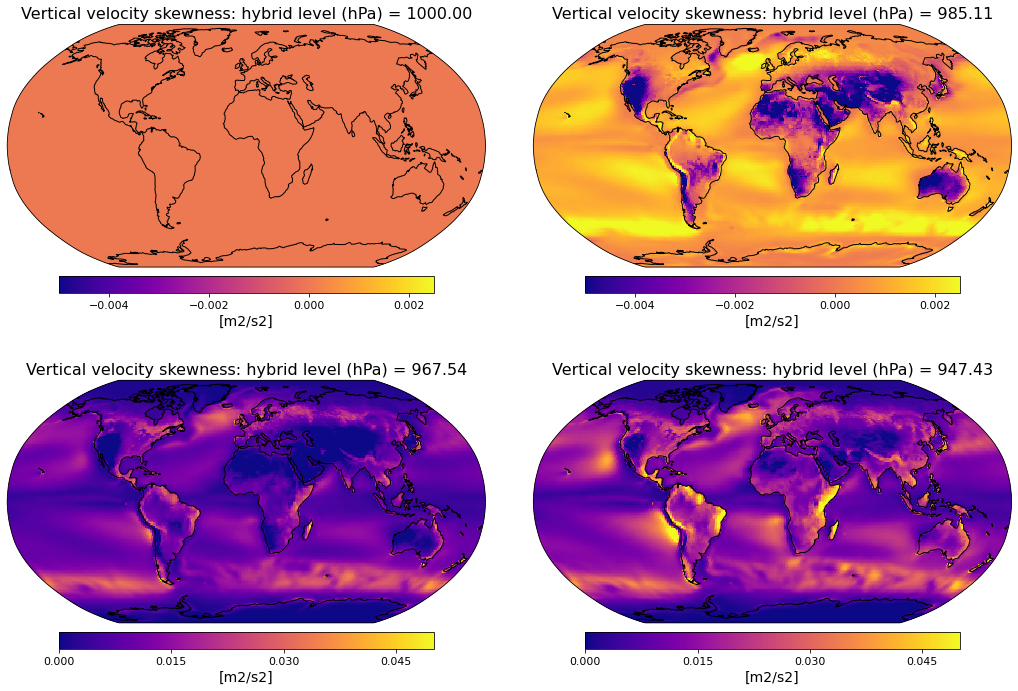

In [108]:
## --- Maps of WP3: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.2,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()


for iLev in range(4):
    # Set global extent
    axs[iLev].set_global()
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    WP3_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(WP3_timeMean[iLev,:,:]), dataDF.lon)
    
    # Might change some cBar levels...
    if iLev<=1:
        cmin = -0.5e-2
        cmax = 0.25e-2
    else:
        cmin = 0
        cmax = 5e-2
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,WP3_cyclic,
                                        vmin=cmin,
                                        vmax=cmax,
                                        cmap='plasma',
                                        transform=ccrs.PlateCarree())
   
    # Add continent outlines 
    axs[iLev].coastlines()
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=4)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=11)
    
    # Set plot title 
    axs[iLev].set_title('Vertical velocity skewness: hybrid level (hPa) = %.2f' % levs[iLev], fontsize=16)


#### Seasonal

Make one *giant* plot to show all four levels and all four seasons 

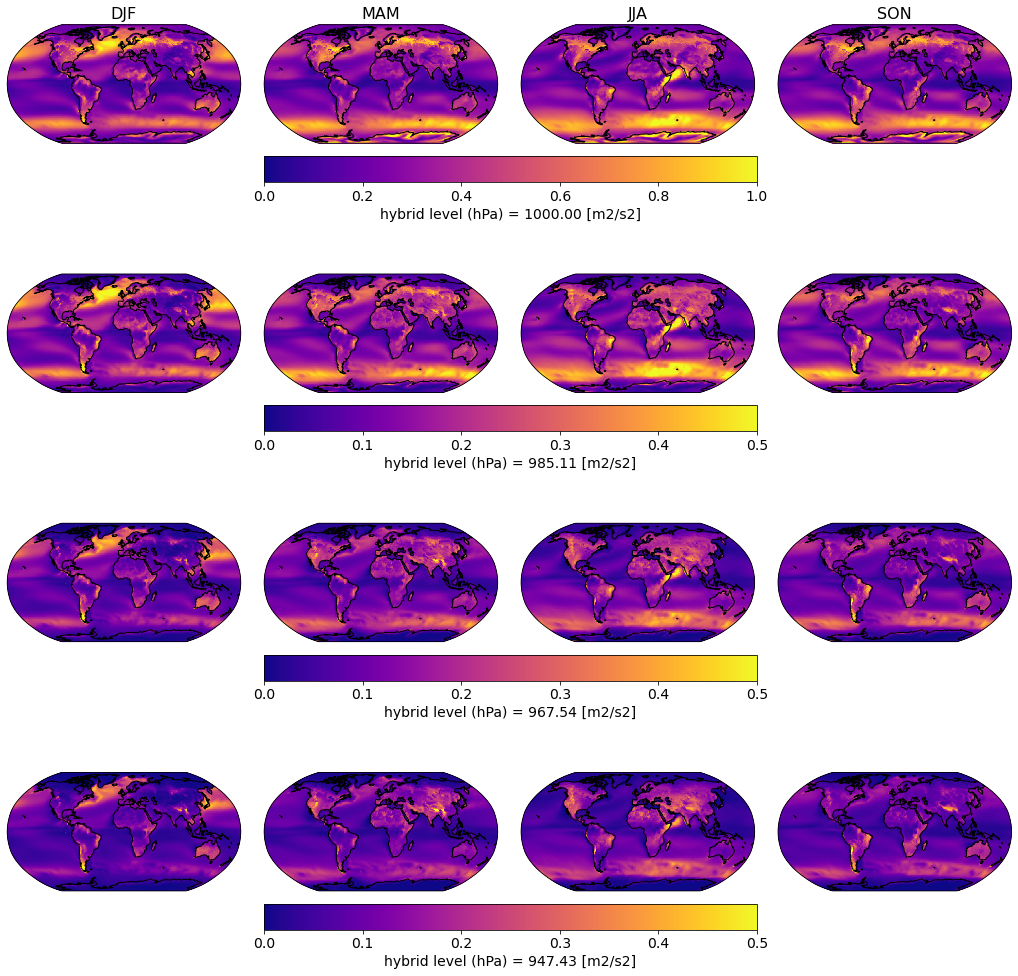

In [114]:
## --- Maps of UP2: 4 lowest levels, seasonal mean --- ##

# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.08,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Define season names 
seasonName = ['DJF','MAM','JJA','SON']

pltInd = 0
for iLev in range(4):
    
    # Specify colorbar range by level 
    if iLev==0:
        cMax = 1
    else: 
        cMax = 0.5
        
    # Get cyclic point for all seasons by level
    UP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
    
    UP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[iLev,:,:]), dataDF.lon)
    UP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[iLev,:,:]), dataDF.lon)
    UP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[iLev,:,:]), dataDF.lon)
    UP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[iLev,:,:]), dataDF.lon)
        
    # Handle each season separately 
    for iSeason in range(4):
        # Set global extent
        axs[pltInd].set_global()
        
        # Contour the (cyclic) field of interest 
        contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(UP2_seasonal[iSeason,:,:]),
                                            vmin=0,
                                            vmax=cMax,
                                            cmap='plasma',
                                            transform=ccrs.PlateCarree())
        
        # Add continent outlines 
        axs[pltInd].coastlines()
        
        # Handle colorbar
        if iSeason==1:
            ax_position = axs[pltInd].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width+0.2, 0.02])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
            # Control number of ticks via 'ticker' in matplotlib 
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
            # Set label and fontsize
            cbar.set_label('hybrid level (hPa) = %.2f [m2/s2]' % levs[iLev],fontsize=14)
            cbar.ax.tick_params(labelsize=14)
    
        # Add some helpful labels 
        if iLev==0:
            axs[pltInd].set_title(seasonName[iSeason], fontsize=16)
    
        # Increment plot index by one
        pltInd = pltInd+1
        

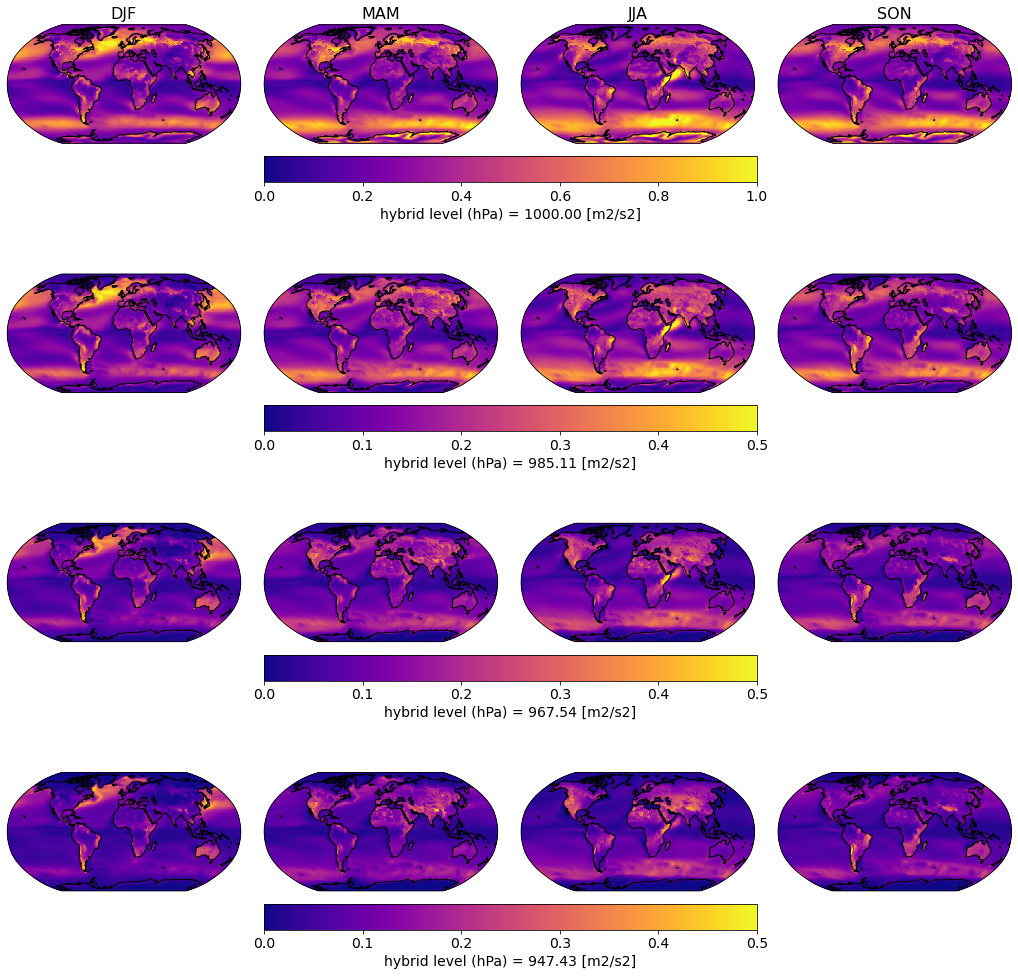

In [118]:
## --- Maps of VP2: 4 lowest levels, seasonal mean --- ##

# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.08,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Define season names 
seasonName = ['DJF','MAM','JJA','SON']

pltInd = 0
for iLev in range(4):
    
    # Specify colorbar range by level 
    if iLev==0:
        cMax = 1
    else: 
        cMax = 0.5
        
    # Get cyclic point for all seasons by level
    VP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
    
    VP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_DJFmean[iLev,:,:]), dataDF.lon)
    VP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_MAMmean[iLev,:,:]), dataDF.lon)
    VP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_JJAmean[iLev,:,:]), dataDF.lon)
    VP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_SONmean[iLev,:,:]), dataDF.lon)
        
    # Handle each season separately 
    for iSeason in range(4):
        # Set global extent
        axs[pltInd].set_global()
        
        # Contour the (cyclic) field of interest 
        contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(VP2_seasonal[iSeason,:,:]),
#                                             vmin=cMin[iSeason],
#                                             vmax=cMax[iSeason],
                                            vmin=0,
                                            vmax=cMax,
                                            cmap='plasma',
                                            transform=ccrs.PlateCarree())
        
        # Add continent outlines 
        axs[pltInd].coastlines()
        
        # Handle colorbar
        if iSeason==1:
            ax_position = axs[pltInd].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width+0.2, 0.02])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
            # Control number of ticks via 'ticker' in matplotlib 
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
            # Set label and fontsize
            cbar.set_label('hybrid level (hPa) = %.2f [m2/s2]' % levs[iLev],fontsize=14)
            cbar.ax.tick_params(labelsize=14)
    
        # Add some helpful labels 
        if iLev==0:
            axs[pltInd].set_title(seasonName[iSeason], fontsize=16)
    
        # Increment plot index by one
        pltInd = pltInd+1
        

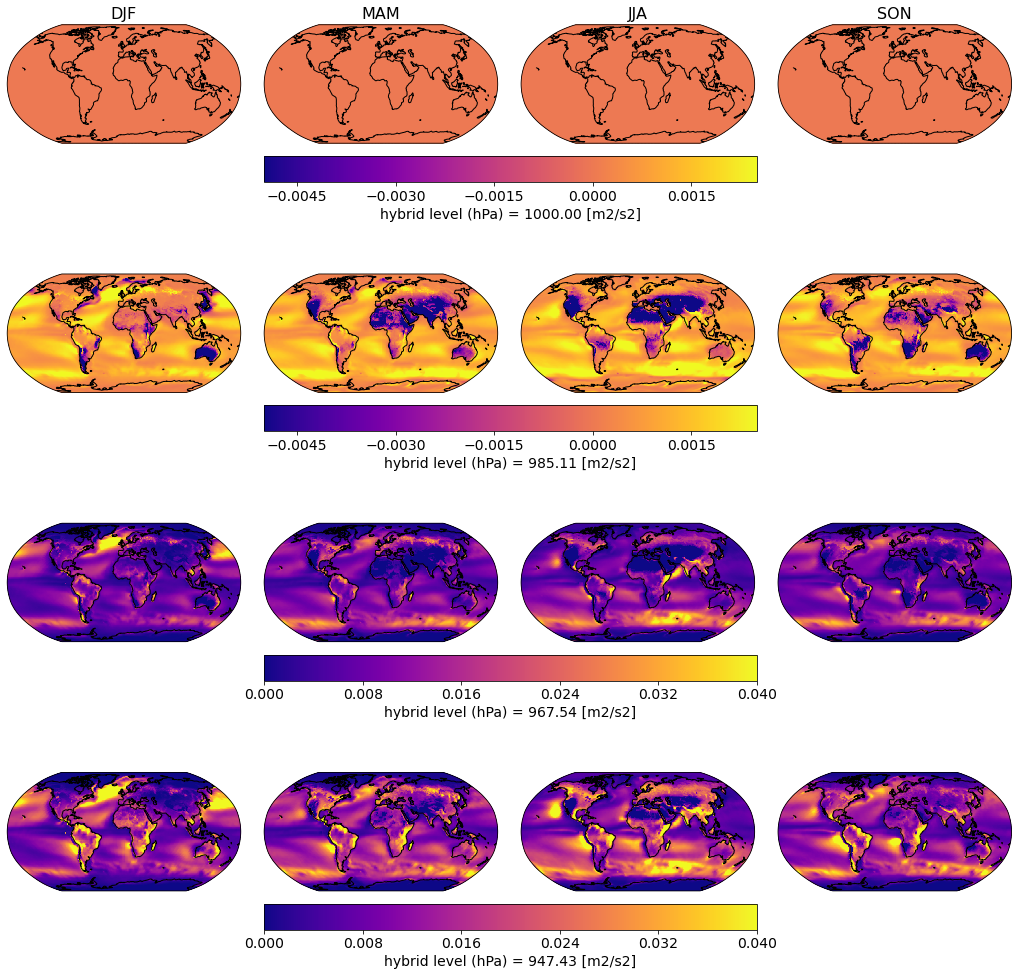

In [121]:
## --- Maps of WP3: 4 lowest levels, seasonal mean --- ##

# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.Robinson()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.08,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Define season names 
seasonName = ['DJF','MAM','JJA','SON']

pltInd = 0
for iLev in range(4):
    
    # Specify colorbar range by level 
    if iLev<=1:
        cMin = -0.5e-2
        cMax = 0.25e-2
    else:
        cMin = 0
        cMax = 4e-2
        
    # Get cyclic point for all seasons by level
    WP3_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
    
    WP3_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(WP3_DJFmean[iLev,:,:]), dataDF.lon)
    WP3_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(WP3_MAMmean[iLev,:,:]), dataDF.lon)
    WP3_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(WP3_JJAmean[iLev,:,:]), dataDF.lon)
    WP3_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(WP3_SONmean[iLev,:,:]), dataDF.lon)
        
    # Handle each season separately 
    for iSeason in range(4):
        # Set global extent
        axs[pltInd].set_global()
        
        # Contour the (cyclic) field of interest 
        contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(WP3_seasonal[iSeason,:,:]),
#                                             vmin=cMin[iSeason],
#                                             vmax=cMax[iSeason],
                                            vmin=cMin,
                                            vmax=cMax,
                                            cmap='plasma',
                                            transform=ccrs.PlateCarree())
        
        # Add continent outlines 
        axs[pltInd].coastlines()
        
        # Handle colorbar
        if iSeason==1:
            ax_position = axs[pltInd].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.03, ax_position.width+0.2, 0.02])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax)
            # Control number of ticks via 'ticker' in matplotlib 
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
            # Set label and fontsize
            cbar.set_label('hybrid level (hPa) = %.2f [m2/s2]' % levs[iLev],fontsize=14)
            cbar.ax.tick_params(labelsize=14)
    
        # Add some helpful labels 
        if iLev==0:
            axs[pltInd].set_title(seasonName[iSeason], fontsize=16)
    
        # Increment plot index by one
        pltInd = pltInd+1
        

### Can we zoom into the US? 

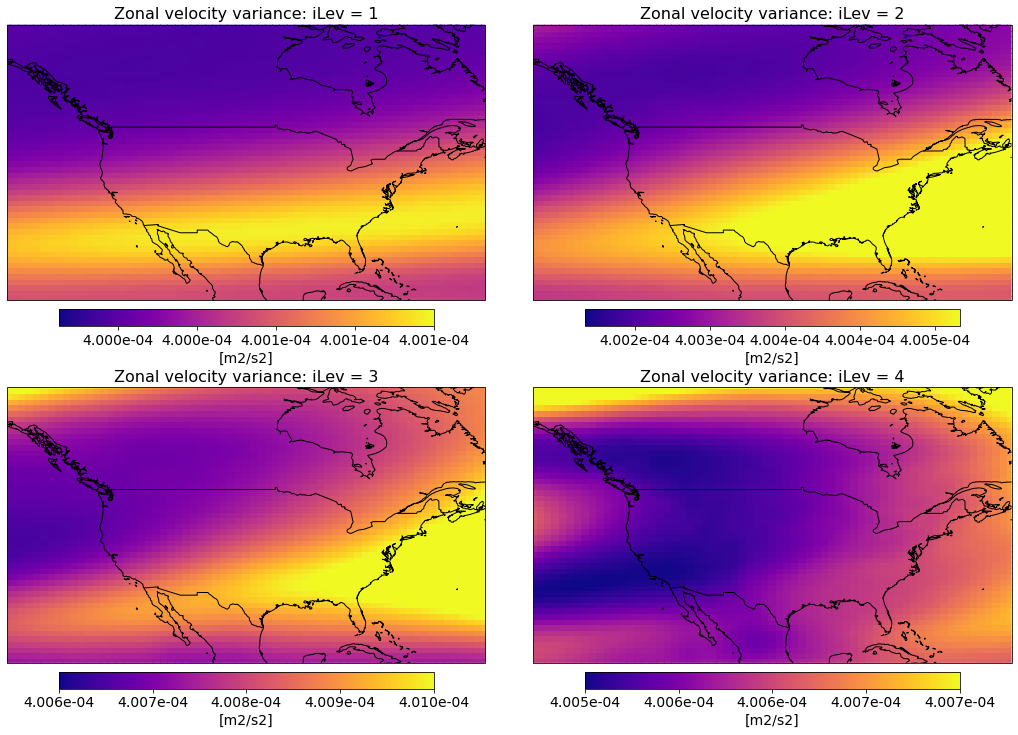

In [241]:
## --- Maps of UP2: 4 lowest levels, all time mean --- ##

# Set up figure 
fig, axs = plt.subplots(2,2, figsize=(18, 12), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.25,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Set contour ranges to vary by level
cMin = [ 4.00005e-4, 4.002e-4, 4.0060e-4, 4.005e-4 ]
cMax = [ 4.00100e-4, 4.005e-4, 4.0100e-4, 4.007e-4 ]

for iLev in range(4):
    # Set US extent
    axs[iLev].set_extent([220,300,20,60])
    
    # Make sure there's a cyclic point (otherwise you get a white line down the middle)
    UP2_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_timeMean[iLev+1,:,:]), dataDF.lon)
    
    # Contour the (cyclic) field of interest 
    contour_plot = axs[iLev].pcolormesh(lon_cyclic,lat,UP2_cyclic,
                                        vmin=cMin[iLev],
                                        vmax=cMax[iLev],
                                        cmap='plasma')
   
    # Add coasts and continent outlines 
    axs[iLev].coastlines()
    axs[iLev].add_feature(cfeature.BORDERS)
    # Add states 
    states_provinces = cfeature.NaturalEarthFeature(    
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')
    axs[iLev].add_feature(states_provinces)
    
    # Add colorbar 
    ax_position = axs[iLev].get_position()
    cbar_ax     = fig.add_axes([ax_position.x0+0.04, ax_position.y0-0.03, ax_position.width-0.08, 0.02])
    cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
    # Control number of ticks via 'ticker' in matplotlib 
    tick_locator = ticker.MaxNLocator(nbins=5)
    cbar.locator = tick_locator
    cbar.update_ticks()
    # Set label and fontsize
    cbar.set_label('[m2/s2]',fontsize=14)
    cbar.ax.tick_params(labelsize=14)
    
    # Set plot title 
    axs[iLev].set_title('Zonal velocity variance: iLev = '+str(iLev+1), fontsize=16)


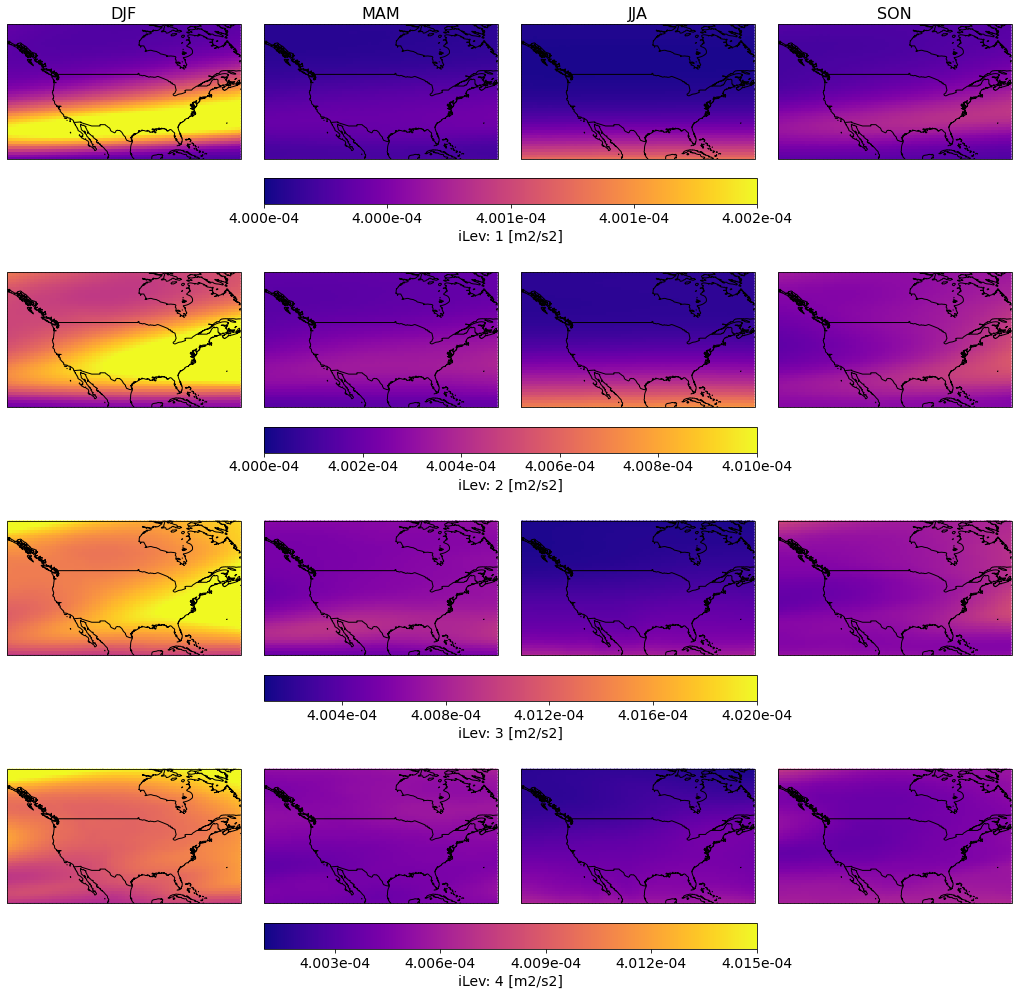

In [246]:
## --- Maps of UP2: 4 lowest levels, seasonal mean --- ##

# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.06,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Define season names 
seasonName = ['DJF','MAM','JJA','SON']

pltInd = 0
for iLev in range(4):
    
    # Specify colorbar range by level 
    #    Note: To vary by season, use commented out arrays. For constant by level, use single values 
    if iLev==0:
#         cMin = [ 4.0000e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04 ]
#         cMax = [ 4.0031e-04, 4.0008e-04, 4.0041e-04, 4.0011e-04 ]
        cMin=4.0000e-4
        cMax=4.0020e-4
    
    elif iLev==1:
#         cMin = [ 4.0002e-04, 4.0000e-04, 4.0000e-04, 4.0000e-04 ]
#         cMax = [ 4.0228e-04, 4.0121e-04, 4.0249e-04, 4.0139e-04 ]
        cMin=4.000e-4
        cMax=4.010e-4

    elif iLev==2:
#         cMin = [ 4.0007e-04, 4.0007e-04, 4.0002e-04, 4.0025e-04 ]
#         cMax = [ 4.0479e-04, 4.0162e-04, 4.0731e-04, 4.0460e-04 ]
        cMin = 4.0010e-4 
        cMax = 4.0200e-4

    elif iLev==3: 
#         cMin = [ 4.0007e-04, 4.0014e-04, 4.0002e-04, 4.0027e-04 ]
#         cMax = [ 4.0398e-04, 4.0124e-04, 4.0400e-04, 4.0400e-04 ]
        cMin = 4.0010e-4
        cMax = 4.0150e-4
        
    # Get cyclic point for all seasons by level
    UP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
    
    UP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_DJFmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_MAMmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_JJAmean[iLev+1,:,:]), dataDF.lon)
    UP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_SONmean[iLev+1,:,:]), dataDF.lon)
        
    # Handle each season separately 
    for iSeason in range(4):
        # Set US extent
        axs[pltInd].set_extent([220,300,20,60])
        
        # Contour the (cyclic) field of interest 
        contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(UP2_seasonal[iSeason,:,:]),
#                                             vmin=cMin[iSeason],
#                                             vmax=cMax[iSeason],
                                            vmin=cMin,
                                            vmax=cMax,
                                            cmap='plasma')
        
        # Add coasts and continent outlines 
        axs[pltInd].coastlines()
        axs[pltInd].add_feature(cfeature.BORDERS)
        # Add states 
        states_provinces = cfeature.NaturalEarthFeature(    
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
        axs[pltInd].add_feature(states_provinces)
        
        # Handle colorbar
        if iSeason==1:
            ax_position = axs[pltInd].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.035, ax_position.width+0.2, 0.02])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
            # Control number of ticks via 'ticker' in matplotlib 
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
            # Set label and fontsize
            cbar.set_label('iLev: '+str(iLev+1)+' [m2/s2]',fontsize=14)
            cbar.ax.tick_params(labelsize=14)
    
        # Add some helpful labels 
        if iLev==0:
            axs[pltInd].set_title(seasonName[iSeason], fontsize=16)
    
        # Increment plot index by one
        pltInd = pltInd+1
        

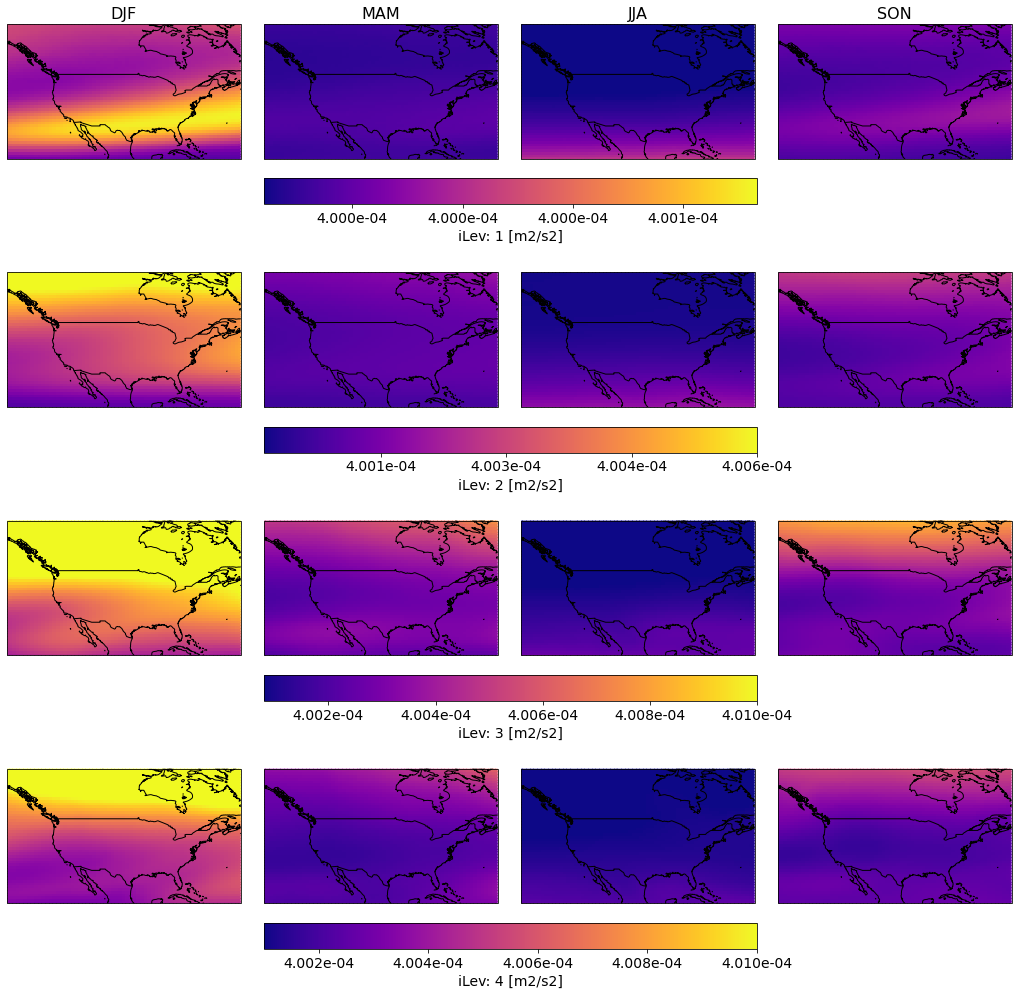

In [249]:
## --- Maps of VP2: 4 lowest levels, seasonal mean --- ##

# Set up figure 
fig, axs = plt.subplots(4,4, figsize=(18, 18), 
                        facecolor='w', edgecolor='k',
                        subplot_kw={'projection':ccrs.PlateCarree()})
#Adjust space between subplots 
fig.subplots_adjust(hspace = 0.06,wspace = 0.1)
#Put axs handles in array, axs 
axs = axs.ravel()

# Define season names 
seasonName = ['DJF','MAM','JJA','SON']

pltInd = 0
for iLev in range(4):
    
    # Specify colorbar ranges
    if iLev==0:
        cMin=4.00003e-04
        cMax=4.00070e-04
    
    elif iLev==1:
        cMin=4.00010e-4
        cMax=4.0060e-4

    elif iLev==2:
        cMin = 4.0008e-4
        cMax = 4.0100e-4

    elif iLev==3: 
        cMin = 4.0010e-4
        cMax = 4.0100e-4
        
    # Get cyclic point for all seasons by level
    VP2_seasonal = np.full([4, len(lat), len(lon)+1], np.nan)
    
    VP2_seasonal[0,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_DJFmean[iLev+1,:,:]), dataDF.lon)
    VP2_seasonal[1,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_MAMmean[iLev+1,:,:]), dataDF.lon)
    VP2_seasonal[2,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_JJAmean[iLev+1,:,:]), dataDF.lon)
    VP2_seasonal[3,:,:], lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(VP2_SONmean[iLev+1,:,:]), dataDF.lon)
        
    # Handle each season separately 
    for iSeason in range(4):
        # Set US extent
        axs[pltInd].set_extent([220,300,20,60])
        
        # Contour the (cyclic) field of interest 
        contour_plot = axs[pltInd].pcolormesh(lon_cyclic,lat,np.squeeze(VP2_seasonal[iSeason,:,:]),
#                                             vmin=cMin[iSeason],
#                                             vmax=cMax[iSeason],
                                            vmin=cMin,
                                            vmax=cMax,
                                            cmap='plasma')
        
        # Add coasts and continent outlines 
        axs[pltInd].coastlines()
        axs[pltInd].add_feature(cfeature.BORDERS)
        # Add states 
        states_provinces = cfeature.NaturalEarthFeature(    
            category='cultural',
            name='admin_1_states_provinces_lines',
            scale='50m',
            facecolor='none')
        axs[pltInd].add_feature(states_provinces)
        
        # Handle colorbar
        if iSeason==1:
            ax_position = axs[pltInd].get_position()
            cbar_ax     = fig.add_axes([ax_position.x0, ax_position.y0-0.035, ax_position.width+0.2, 0.02])
            cbar        = plt.colorbar(contour_plot, orientation='horizontal', cax=cbar_ax, format='%.3e')
            # Control number of ticks via 'ticker' in matplotlib 
            tick_locator = ticker.MaxNLocator(nbins=5)
            cbar.locator = tick_locator
            cbar.update_ticks()
            # Set label and fontsize
            cbar.set_label('iLev: '+str(iLev+1)+' [m2/s2]',fontsize=14)
            cbar.ax.tick_params(labelsize=14)
    
        # Add some helpful labels 
        if iLev==0:
            axs[pltInd].set_title(seasonName[iSeason], fontsize=16)
    
        # Increment plot index by one
        pltInd = pltInd+1
        

## [Old] Testing section

**Maybe interpolate?**

In [48]:
p0   = 1000.
pnew = [1000,975,950,925,900,850,800,750,700,600,500]

hyai = dataDF.hyai.values
hybi = dataDF.hybi.values

PS  = presDF.PS
UP2 = dataDF.UP2_CLUBB


Some context: The final argument provided to vinth2p indicates whether or not to extrapolate when the pressure level requested is outside the range of PS. For a lot of regions on the globe, that could certainly cause issue for the lower levels. So let's just take a quick look at PS average in a given month.

Text(0.5, 1.0, 'Sfc Pressure (iTime=1)')

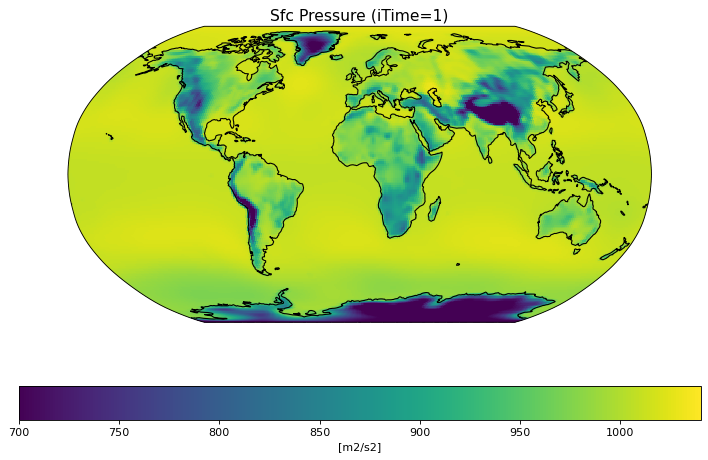

In [46]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
PS_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(PS[1,:,:]), dataDF.lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,dataDF.lat,PS_cyclic/100.0,vmin=700,vmax=1040,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[m2/s2]',orientation='horizontal')
ax.set_title('Sfc Pressure (iTime=1)', fontsize=14)



<br> Now do the actual interpolation <br>

In [49]:
# Interpolate to constant pressure levels 
UP2_new = Ngl.vinth2p(UP2,hyai,hybi,pnew,PS,1,p0,1,False)


In [51]:
# Check that arrays have expected size with new levels
print('Shape of not-interpolated data:', np.shape(UP2))
print('Shape of interpolated data:', np.shape(UP2_new))


Shape of not-interpolated data: (108, 33, 192, 288)
Shape of interpolated data: (108, 11, 192, 288)


In [52]:
# Average over time 
UP2_avg    = np.nanmean(UP2,0)
UP2new_avg = np.nanmean(UP2_new,0)


### Take a look at some summary statistics

In [58]:
len(dataDF.lat)

192

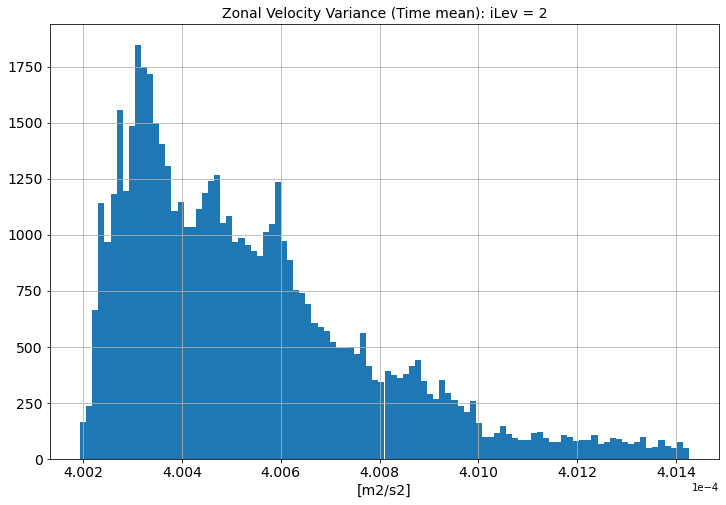

In [84]:
# --- For old data --- # 

# Specify level 
iLev = 2
UP2_reshape = np.squeeze(UP2_avg[iLev,:,:]).reshape((len(dataDF.lat)*len(dataDF.lon), 1))

# Plot histogram at various levels 
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

n, bins, patches = ax1.hist(UP2_reshape, 100)
ax1.grid()
ax1.set_title('Zonal Velocity Variance (Time mean): iLev = '+str(iLev), fontsize=14)
ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
ax1.set_xlabel('[m2/s2]',fontsize=14)
ax1.tick_params(labelsize=14)
plt.show()


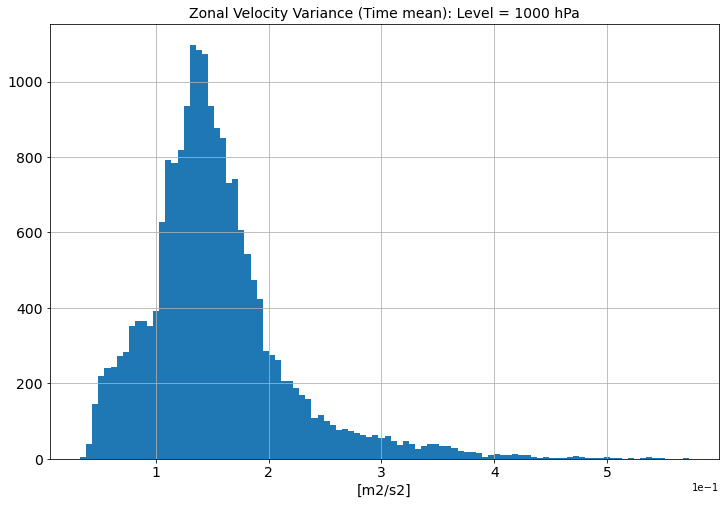

In [83]:
# --- For new data --- # 

# Specify level 
iLev = 0
UP2new_reshape = np.squeeze(UP2new_avg[iLev,:,:]).reshape((len(dataDF.lat)*len(dataDF.lon), 1))
# When data can't be extrapolated, seems like the fill value is 1e30. Set to NaN instead 
UP2new_reshape[UP2new_reshape==1e30] = np.nan 

# Plot histogram at various levels 
fig, ax1 = plt.subplots()
fig.set_size_inches(12,8)

n, bins, patches = ax1.hist(UP2new_reshape, 100)
ax1.grid()
ax1.set_title('Zonal Velocity Variance (Time mean): Level = '+str(pnew[iLev])+' hPa', fontsize=14)
ax1.ticklabel_format(style='sci',axis='x',scilimits=(0,0))
ax1.set_xlabel('[m2/s2]',fontsize=14)
ax1.tick_params(labelsize=14)
plt.show()



Even if I mask out some of the crazy high values from vinth2p, we're still getting much bigger values of UP2_CLUBB after running the extrapolation. It feels like that would be a sign that this isn't working quite right. But, I do think it's better to stick with the sigma level anyway for right now, so I'm going to put a pin in the interpolation here.

### Try plotting

Text(0.5, 1.0, 'Zonal velocity variance (2nd lowest level; time mean, 1951-59)')

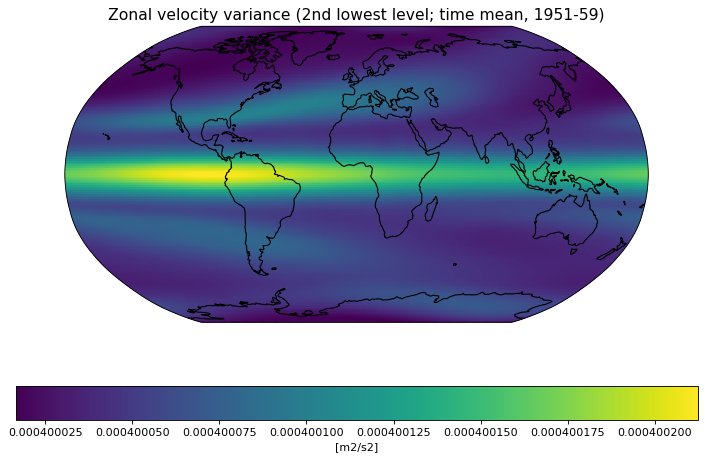

In [29]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
UP2avg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2_avg[1,:,:]), dataDF.lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,dataDF.lat,UP2avg_cyclic,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[m2/s2]',orientation='horizontal')
ax.set_title('Zonal velocity variance (2nd lowest level; time mean, 1951-59)', fontsize=14)


Text(0.5, 1.0, 'Zonal velocity variance (800 mb; time mean, 1951-59)')

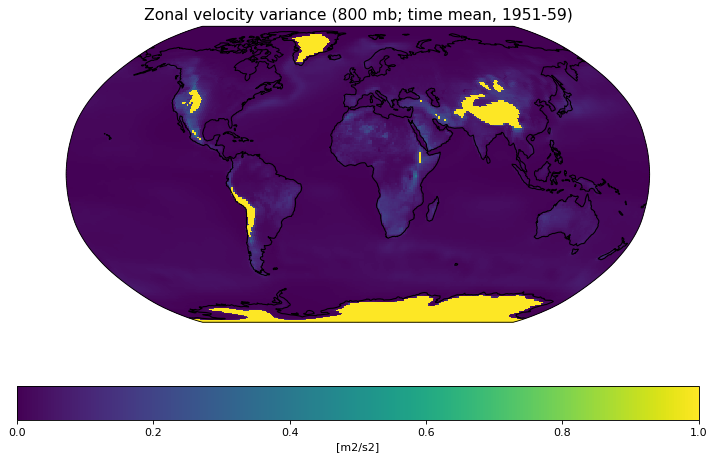

In [37]:
fig=plt.figure(figsize=(11, 7), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111, projection=ccrs.Robinson())
ax.set_global()

# Add cyclic point (where lon goes from 360˚ to 0˚) -- othwerwise, blank line 
UP2avg_cyclic, lon_cyclic = cartopy.util.add_cyclic_point(np.squeeze(UP2new_avg[6,:,:]), dataDF.lon)

# Make plot
contour_plot = ax.pcolormesh(lon_cyclic,dataDF.lat,UP2avg_cyclic,vmin=0,vmax=1,transform=ccrs.PlateCarree())
ax.coastlines()
cbar = plt.colorbar(contour_plot, label='[m2/s2]',orientation='horizontal')
ax.set_title('Zonal velocity variance (800 mb; time mean, 1951-59)', fontsize=14)

